In [1]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
# from  https://naysan.ca/2022/12/29/drawing-state-transition-diagrams-in-python-improved-version/
class Node():

    def __init__(
        self, center, radius, label,
        facecolor='#2653de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3',
        **kwargs
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]

        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor

        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.07

        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': kwargs.get("node_fontsize", 12)
        }


    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle],
            edgecolor = self.node_edgecolor,
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label,
            xy = self.center,
            color = '#ffffff',
            **self.text_args
        )


    def add_self_loop(self, ax, prob=None, direction='up', annotate = True, percentages = False):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15

        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y),
            self.radius,
            start,
            angle,
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow],
            edgecolor = self.ring_edgecolor,
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        if prob and annotate:
            text = f"{prob}"
            text += "%" if percentages else ""
            ax.annotate(text, xy=(self.x, prob_y+0.5), color='#000000', **self.text_args)

In [2]:
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar

# module from this repository
class MarkovChain:

    def __init__(self, M, labels, **kwargs):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
            - kwargs    Keywords to modify how data is displayed, specifically:
                        annotate          if False, probabilities aren't shown
                        arrow_edgecolor
                        arrow_facecolor
                        arrow_head_width
                        arrow_width
                        fontsize          affects transition probability labels
                        node_edgecolor
                        node_facecolor
                        node_fontsize     affects node labels
                        node_radius
                        percentages       bool, if True probabilites should be
                                          displayed as percentages instead of decimals
                        transparency_func function to determine transparency of arrows (default: alpha = prob)
        """

        np.set_printoptions(precision=3,suppress=True)



        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        # save args
        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        self.save_kwargs(**kwargs)



        # Build the network
        self.build_network()

    def save_kwargs(self, **kwargs):

        # save the dictionary
        self.kwargs = kwargs

        # Colors
        self.arrow_facecolor = self.kwargs.get("arrow_facecolor", '#a3a3a3')
        self.arrow_edgecolor = self.kwargs.get("arrow_edgecolor", '#a3a3a3')
        self.node_facecolor = self.kwargs.get("node_facecolor", '#2693de')
        self.node_edgecolor = self.kwargs.get("node_edgecolor", '#e6e6e6')

        # Drawing config
        self.node_radius = self.kwargs.get("node_radius", 0.60)
        self.arrow_width = self.kwargs.get("arrow_width", 0.005)
        self.arrow_head_width = self.kwargs.get("arrow_head_width", 0.12)
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': self.kwargs.get("fontsize", 14)
        }

        # How to represent the probabilities
        self.percentages = self.kwargs.get("percentages", False)
        self.annotate_probabilities = self.kwargs.get("annotate", True)
        self.transparency_func = self.kwargs.get("transparency_func", lambda p: p)


    def set_node_centers(self):
        """
            Spread the nodes evenly around in a circle using Euler's formula
            e^(2pi*i*k/n), where n is the number of nodes and k is the
            index over which we iterate. The real part is the x coordinate,
            the imaginary part is the y coordinate. Then scale by n for more room.

            self.node_centers is a numpy array of shape (n,2)
        """

        # For legibility, we use n below
        n = self.n_states

        # generate the evenly spaced coords on the unit circle
        unit_circle_coords = np.fromfunction(lambda x,y:
                        (1-y)*np.real(np.exp(2 * np.pi * x/n * 1j))
                        + y * np.imag(np.exp(2 * np.pi * x/n * 1j)),
                        (n,2))

        self.figsize = (n*2+2, n*2+2)
        self.xlim = (-n-1, n+1)
        self.ylim = (-n-1, n+1)

        # Scale by n to have more room
        self.node_centers = unit_circle_coords * n


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = [Node(self.node_centers[i],
                           self.node_radius,
                           self.labels[i],
                           **self.kwargs) for i in range(self.n_states)]


    def add_arrow(self, ax,
                  node1, node2,
                  prob=None, width=None,
                  head_width=None,
                  annotate = True,
                  arrow_spacing = 0.15,
                  transparency_func = None):
        """
        Add a directed arrow between two nodes

        Keywords:

        annotate:                if True, probability is displayed on top of the arrow
        arrow_spacing:           determines space between arrows in opposite directions
        head_width:              width of arrow head
        prob:                    probability of going from node1 to node2
        transparency_func:       function to determine transparency of arrows
        width:                   width of arrow body
        """


        if width is None:
            width = self.arrow_width
        if head_width is None:
            head_width = self.arrow_head_width
        if transparency_func is None:
            transparency_func = self.transparency_func

        # x,y start of the arrow, just touching the starting node
        x_start = node1.x + node1.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        y_start = node1.y + node1.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # find the arrow length so it just touches the ending node
        dx = node2.x-x_start - node2.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        dy = node2.y-y_start - node2.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # calculate offset so arrows in opposite directions are separate

        x_offset = dy / np.sqrt(dx**2+dy**2) * arrow_spacing
        y_offset = -dx / np.sqrt(dx**2+dy**2) * arrow_spacing

        arrow = mpatches.FancyArrow(
            x_start + x_offset,
            y_start + y_offset,
            dx,
            dy,
            width = width,
            head_width = head_width,
            length_includes_head = True
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor
        )
        ax.add_collection(p)

        # Add label of probability at coordinates (x_prob, y_prob)
        x_prob = x_start +  0.2*dx + 1.2 * x_offset
        y_prob = y_start +  0.2*dy + 1.2 * y_offset

        if prob and annotate:
            text = f"{prob}"
            text += "%" if self.percentages else ""
            ax.annotate(text, xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)
        print(self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(-5.5,5.5)
        print(self.ylim)
        scalebar = ScaleBar(2.51, "km")
        plt.gca().add_artist(scalebar)
        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j:
                    self.nodes[i].add_self_loop(ax,
                                                prob = self.M[i,j],
                                                direction = 'up' if self.nodes[i].y >= 0 else 'down',
                                                annotate = self.annotate_probabilities,
                                                percentages = self.percentages)

                # directed arrows
                else:
                    self.add_arrow(ax,
                                   self.nodes[i],
                                   self.nodes[j],
                                   prob = self.M[i,j],
                                   annotate = self.annotate_probabilities)

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()

(10, 10)
(-5, 5)


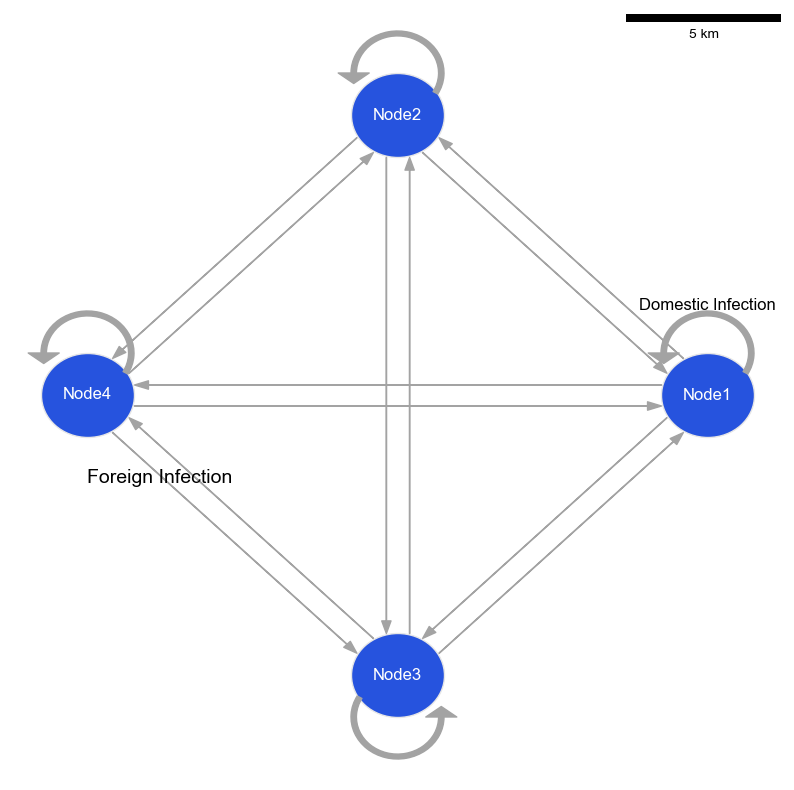

In [3]:
P = np.array([
    ["Domestic Infection", "", "", ""],
    ["", "", "", ""],
    ["", "", "", "Foreign Infection"],
    ["", "", "", ""]
])
mc = MarkovChain(P, ['Node1', 'Node2', 'Node4', 'Node3'])
mc.draw("MD2.png")